# Learning

The shallowest network is one that has no hidden layers at all. But this type of network can only solve one type of problem: those that are **linearly separable**. This notebook explores learning linearly and non-linearly separable datasets.

## Linearly Separable

In [1]:
import conx as cx
import random

Using TensorFlow backend.
ConX, version 3.7.5


First, let's construct a fake linearly-separable dataset.

In [2]:
count = 500

positives = [(i/count, i/(count * 2) + random.random()/6) for i in range(count)]
negatives = [(i/count, 0.3 + i/(count * 2) + random.random()/6) for i in range(count)]

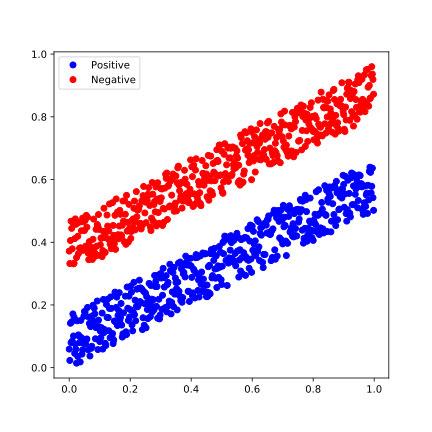

In [3]:
cx.scatter([
         ["Positive", positives], 
         ["Negative", negatives],
        ], 
    symbols={"Positive": "bo", "Negative": "ro"})

Let's make a dataset out of these two types:

In [4]:
ds = cx.Dataset()

A dataset is composed of:

* inputs - the (x,y)
* targets - [0] or [1]
* labels - a string representing the category

In [5]:
ds.load([(p, [ 1.0], "Positive") for p in positives] +
        [(n, [ 0.0], "Negative") for n in negatives])

Although the patterns will be shuffled during training, we will also shuffle them here just to make it clear that as we view them that the target should be determined from the (x,y) values.

In [6]:
ds.shuffle()

We will save 10% of the patterns for testing/validation:

In [7]:
ds.split(.1)

And finally, we look at the dataset summary to make sure it looks right:

In [8]:
ds.summary()

_________________________________________________________________
Unnamed Dataset:
Patterns    Shape                 Range                         
inputs      (2,)                  (0.0, 0.998)                  
targets     (1,)                  (0.0, 1.0)                    
Total patterns: 1000
   Training patterns: 900
   Testing patterns: 100
_________________________________________________________________


Now we are ready to design the network. This one is fairly easy: the inputs and outputs are determined by the dataset. We need only determine the error function, the optimizer, and the activation function on the output layer:

In [9]:
net = cx.Network("Linearly Separable", 2, 1, activation="sigmoid")
net.compile(error="mae", optimizer="adam") 

We associate the dataset with the network:

In [10]:
net.set_dataset(ds)

And let's use the dashboard to see the dataset and network:

In [11]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

How complicated is this network?

In [12]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


We can get a flat array of these weights with `net.to_array()`:

In [13]:
net.to_array()

[1.0339814, -0.73224044, 0.0]

Before training, let's see how bad the network does with these random weights:

In [14]:
net.test(tolerance=0.4)

Testing validation dataset with tolerance 0.4...
Total count: 900
      correct: 123
      incorrect: 777
Total percentage correct: 0.13666666666666666


Also, we can use the `net.plot_activation_map()` method that Lisa introduced in the "Getting Started with ConX" notebook.

Recall that the method will sample from the range of possible inputs of two units of an input layer, and will show you a "heatmap" of the resulting activation of one unit in any hidden or output layer. 

By default, it will use the first two units of a layer named "input" and will propagate to the first unit of a layer called "output". This matches our network exactly, so we can just use the defaults.

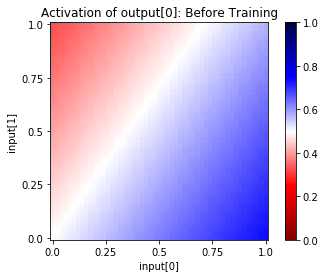

In [15]:
net.plot_activation_map(title="Before Training")

In addition, we can also put scatter plot on top of the activations, and give those points a legend by using the net.test() method again, but this time with interactive=False:

In [16]:
# net.test(tolerance=0.4, interactive=False)

This will return a list of tuples in the form:

("LABEL (correct | wrong)", INPUTS)

like so:

```python
[('Negative (correct)',
  [[0.5239999890327454, 0.7271904349327087],
  ...
   [0.33000001311302185, 0.5292619466781616]]),
 ('Positive (wrong)',
  [[0.08399999886751175, 0.3982737064361572],
  ...
   [0.33000001311302185, 0.5292619466781616]]),
 ('Positive (correct)',
  [[0.08399999886751175, 0.3982737064361572],
  ...
   [0.33000001311302185, 0.5292619466781616]]),
 ('Negative (wrong)',
  [[0.08399999886751175, 0.3982737064361572],
   ...
   [0.014000000432133675, 0.05173352733254433]])]
```

Putting that all together, with a dictionary of symbols, gives:

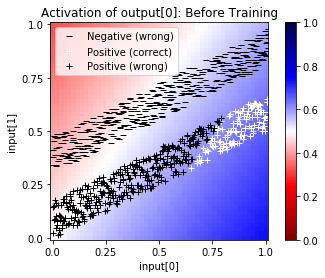

In [17]:
symbols = {
    "Positive (correct)": "w+",
    "Positive (wrong)": "k+",
    "Negative (correct)": "w_",
    "Negative (wrong)": "k_",
}

net.plot_activation_map(scatter=net.test(tolerance=0.4, interactive=False), 
                        symbols=symbols, title="Before Training")

Ok, now we are ready to train the network:

In [18]:
#net.delete()
#net.reset()

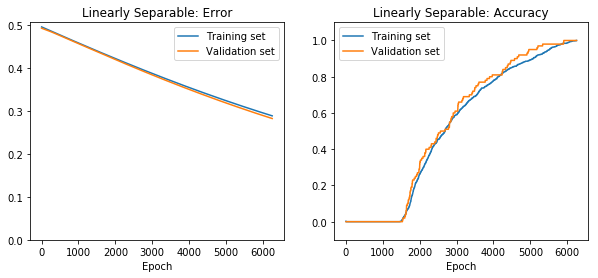

In [19]:
if net.saved():
    net.load()
    net.plot_results()
else:
    net.train(epochs=10000, accuracy=1.0, report_rate=50, 
             tolerance=0.4, batch_size=len(net.dataset.train_inputs), 
             plot=True, record=100, save=True)

Now we can see the trained network on the training set:

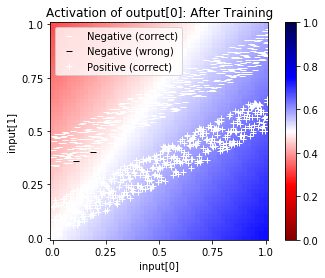

In [20]:
net.plot_activation_map(scatter=net.test(tolerance=0.4, interactive=False), 
                        symbols=symbols, title="After Training")

Now, we can see the weights after training:

In [21]:
net.to_array()

[3.086318, -6.2050633, 1.4618336]

To verify the network so see that it is computing the outputs as expected, we can manually do the math.

That is, the sigmoid(sum of the inputs * weights + bias) should gives us the same output as net.propagate().

In [22]:
from conx.activations import sigmoid

def output(x, y):
    wts = net.get_weights("output")
    return sigmoid(x * wts[0][1][0] + y * wts[0][0][0] + wts[1][0])

def ascii(f):
    return "%4.1f" % f

We can use that to make our own ASCII heatmap:

In [23]:
for y in cx.frange(0, 1.1, .1):
    for x in cx.frange(1.0, 0.1, -0.1):
        print(ascii(output(x, y)), end=" ")
    print()

 0.0  0.0  0.0  0.1  0.1  0.2  0.3  0.4  0.6 
 0.0  0.0  0.0  0.1  0.1  0.2  0.3  0.5  0.6 
 0.0  0.0  0.1  0.1  0.2  0.3  0.4  0.6  0.7 
 0.0  0.0  0.1  0.1  0.2  0.3  0.5  0.6  0.8 
 0.0  0.1  0.1  0.2  0.3  0.4  0.6  0.7  0.8 
 0.0  0.1  0.1  0.2  0.3  0.5  0.6  0.8  0.9 
 0.1  0.1  0.2  0.3  0.4  0.6  0.7  0.8  0.9 
 0.1  0.1  0.2  0.3  0.5  0.6  0.8  0.9  0.9 
 0.1  0.2  0.3  0.4  0.6  0.7  0.8  0.9  0.9 
 0.1  0.2  0.3  0.5  0.6  0.8  0.9  0.9  1.0 
 0.2  0.3  0.4  0.6  0.7  0.8  0.9  0.9  1.0 


Finally, it would be very useful to see how learning works over time. For this, we can use the net.playback() method. It takes a function of the form:

```python
def function(network, epoch):
    return IMAGE
```

The function is given the network as it was at the time of EPOCH. That is, the network is transported back in time.

We use a variation of the plot_activation_map:

SequenceViewer(children=(VBox(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description…

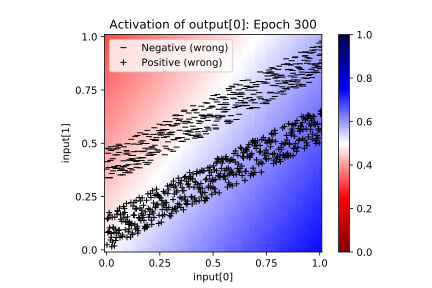

In [24]:
net.playback(lambda net, epoch: net.plot_activation_map(title="Epoch %s" % epoch, 
                                                        scatter=net.test(tolerance=0.4, interactive=False), 
                                                        symbols=symbols, 
                                                        format="svg"))

In [25]:
net.set_weights_from_history(-1)

In [26]:
# net.movie(lambda net, epoch: net.plot_activation_map(title="Epoch %s" % epoch, 
#                                                      scatter=net.test(tolerance=0.4, interactive=False), 
#                                                      symbols=symbols, 
#                                                      format="image"))

## Non-Linearly Separable

In [27]:
import math

In [28]:
def distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [29]:
negatives = []
while len(negatives) < 500:
    x = random.random()
    y = random.random()
    d = distance(x, y, 0.5, 0.5)
    if d > 0.375 and d < 0.5:
        negatives.append([x, y])
positives = []
while len(positives) < 500:
    x = random.random()
    y = random.random()
    d = distance(x, y, 0.5, 0.5)
    if d < 0.25:
        positives.append([x, y])

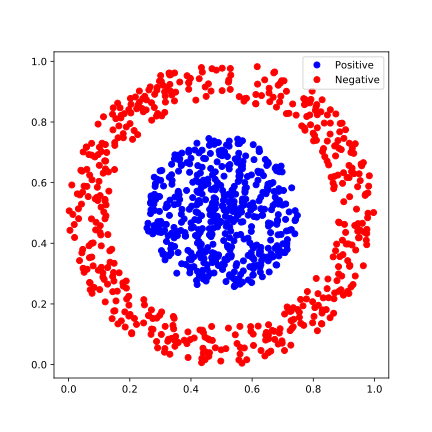

In [30]:
cx.scatter([
         ["Positive", positives], 
         ["Negative", negatives],
        ], 
    symbols={"Positive": "bo", "Negative": "ro"})

In [31]:
net = cx.Network("Non-Linearly Separable", 2, 5, 1, activation="sigmoid")
net.compile(error="mae", optimizer="adam") 


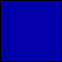
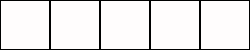
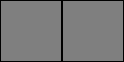

In [32]:
net.picture()

In [33]:
ds = cx.Dataset()

In [34]:
ds.load([(p, [ 1.0], "Positive") for p in positives] +
        [(n, [ 0.0], "Negative") for n in negatives])

In [35]:
ds.shuffle()

In [36]:
ds.split(.1)

In [37]:
net.set_dataset(ds)

In [38]:
net.test(tolerance=0.4)

Testing validation dataset with tolerance 0.4...
Total count: 900
      correct: 449
      incorrect: 451
Total percentage correct: 0.4988888888888889


In [39]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

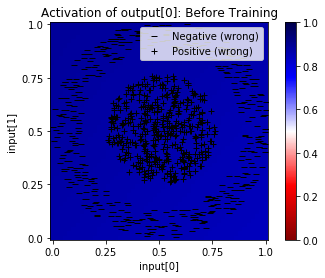

In [40]:
net.plot_activation_map(scatter=net.test(interactive=False), symbols=symbols, title="Before Training")

You may want to either `net.reset()` or `net.retrain()` if the following cell doesn't complete with 100% accuracy. Calling `net.reset()` may be needed if the network has landed in a local maxima; `net.retrain()` may be necessary if the network just needs additional training.

In [41]:
# net.delete()
# net.reset()

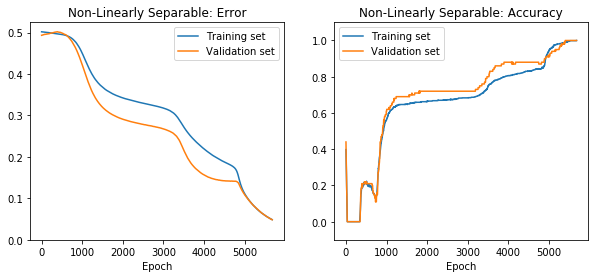

In [42]:
if net.saved():
    net.load()
    net.plot_results()
else:
    net.train(epochs=10000, accuracy=1.0, report_rate=50, 
              tolerance=0.4, batch_size=256, 
              plot=True, record=100, save=True)

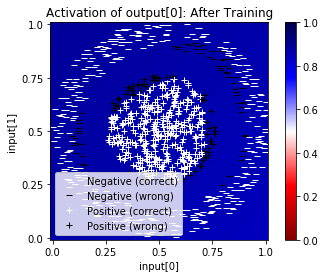

In [43]:
net.plot_activation_map(scatter=net.test(interactive=False), symbols=symbols, title="After Training")

In [44]:
for y in cx.frange(0, 1.1, .1):
    for x in cx.frange(1.0, 0.1, -0.1):
        print(ascii(net.propagate([x, y])[0]), end=" ")
    print()

 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 0.0  0.0  0.0  0.2  0.3  0.4  0.3  0.1  0.1 
 0.0  0.1  0.2  0.7  0.9  1.0  0.9  0.7  0.2 
 0.0  0.1  0.4  0.9  1.0  1.0  1.0  1.0  0.8 
 0.0  0.1  0.4  0.9  1.0  1.0  1.0  1.0  0.8 
 0.0  0.1  0.4  0.9  1.0  1.0  1.0  0.9  0.4 
 0.0  0.1  0.3  0.8  0.9  0.9  0.8  0.3  0.0 
 0.0  0.0  0.2  0.5  0.6  0.5  0.1  0.0  0.0 
 0.0  0.0  0.0  0.1  0.1  0.0  0.0  0.0  0.0 
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 


SequenceViewer(children=(VBox(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description…

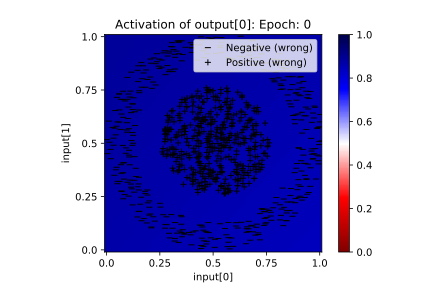

In [45]:
net.playback(lambda net, epoch: net.plot_activation_map(title="Epoch: %s" % epoch, 
                                                        scatter=net.test(interactive=False),
                                                        symbols=symbols,
                                                        format="svg"))

In [46]:
# net.movie(lambda net, epoch: net.plot_activation_map(title="Epoch %s" % epoch, 
#                                                      scatter=net.test(tolerance=0.4, interactive=False), 
#                                                      symbols=symbols, 
#                                                      format="image"))

The above cell, when run, will create and display the movie. It may take a few minutes to create. If you don't see it above, you can also click on the link <a href="Non-Linearly_Separable-movie.mp4">Non-Lineraly_Separable-Movie.mp4</a> to see it.